In [21]:
cd ../Python/

/home/mfruman/DataSci/PBN/Python


In [22]:
import readPBNData.description as rd
import readPBNData.images as ri
import PBNFeatures.paletteTools as pt
import PBNPCA.pca as pbnpca
import numpy as np

In [23]:
csvs, fileLike = rd.openZip('../Data/train_info.csv.zip')
lines, head = rd.readCSV(fileLike[0])

In [24]:
cols = rd.columns(lines,head)
cols.keys()

['style', 'title', 'artist', 'filename', 'date', 'genre']

In [25]:
# find 10 artists with most paintings in data set
artistTable = rd.table(cols['artist'])
artistTable[:5]

[('3cc9a44380296d93e68b71a27643c25f', 413),
 ('96e7b1bc8d52e18caf0af34fec2e9bcb', 402),
 ('d8a3c897c506be7de91d8f892f14f934', 401),
 ('3f8dc381ccfe9d5cc88b75970262715b', 400),
 ('10bc951c2eb4a2f05fa773bdaace4e3b', 397)]

In [26]:
# images in train_1.zip and train_2.zip file
train_1_names = rd.imagesInZip('../Data/train_1.zip')
train_2_names = rd.imagesInZip('../Data/train_2.zip')

In [27]:
# show (full) image
def showImage(imgName):
    if (imgName in train_1_names):
        ri.openZipImage('../Data/train_1.zip', \
                        imgName, \
                        prefix='train_1' \
                       ).show()
    else:
        ri.openZipImage('../Data/train_2.zip', \
                        imgName, \
                        prefix='train_2' \
                       ).show()

In [28]:
# if it exists, load the json text file containing list of 
# 10 most prolific artists and the filenames of their paintings
# contained in train_1.zip and train_2.zip, assume miniatures
# and cutouts already exist (can refactor later to check)
#
# else, scan zip files, create miniatures, cutouts, json index file
#
import os.path
import json
featureDir = '../Data/'
portfoliosFile = featureDir + 'portfolios_top10.json'
if (os.path.isfile(portfoliosFile)):
    with open(portfoliosFile,'r') as jsonfile:
        portfolios_uni = json.load(jsonfile)
        print('reading reading reading!!!')
else:
    # if json file doesn't exist, then go through steps to create
    # miniatures and cutouts (if necessary) and then
    # create json file

    # number of paintings by artist in train_1 and train_2
    # distinct artists (slowish)
    distinctArtists = [a[0] for a in artistTable]
    paintingsIn12 = []
    print('scanning for paintings by top ten in full csv file . . .')
    for artist in distinctArtists:
        # print('    scanning artist ' + artist + ' . . . ')
        paintingsIn12.append(len(rd.sameArtist(artist, cols, imageList=train_1_names))
                            +len(rd.sameArtist(artist, cols, imageList=train_2_names)))
    artistTable12 = sorted(zip(distinctArtists, paintingsIn12), 
                           key=lambda item: item[1], reverse=True)
    print('top 10 artists . . . ')
    print(artistTable12[:10])

    # lists of paintings by the 10 most prolific artists in train_1 and train_2 
    # extract artist names from artistTable
    print('\nscanning for paintings by top ten in zip files . . .')
    leaders = [a[0] for a in artistTable12[:10]]
    portfolios1 = []
    portfolios2 = []
    for artist in leaders:
        print('    scanning artist ' + artist + ' . . . ')
        # paintings in train_1.zip
        portfolios1.append(rd.sameArtist(artist, cols, imageList=train_1_names))
        # paintings in train_2.zip
        portfolios2.append(rd.sameArtist(artist, cols, imageList=train_2_names))
    # list of artists and (separate) lists of paintings in train_1 and train_2
    portfolios = zip(leaders,portfolios1,portfolios2)
    # list of artists and single list of paintings
    portfolios_uni = [(artist, p1 + p2) for (artist,p1,p2) in portfolios]

    # create miniatures of the paintings by most prolific artists and save them to disk
    # (if file exists, does nothing)
    print('\ncreating miniatures (if necessary) . . . ')
    for portfolio in portfolios:
        print('    artist ' + portfolio[0] + ' . . . ')
        minifiles_1 = ri.miniatures('../Data/train_1.zip', \
                                    portfolio[1],prefix='train_1',size=(100,100))
        minifiles_2 = ri.miniatures('../Data/train_2.zip', \
                                    portfolio[2],prefix='train_2',size=(100,100))
    # create cutouts of the paintings by most prolific artists and save them to disk
    # (if file exists, does nothing)
    print('\ncreating cutouts (if necessary) . . . ')
    for portfolio in portfolios:
        print('    artist ' + portfolio[0] + ' . . . ')
        cutoutfiles_1 = ri.cutouts('../Data/train_1.zip', \
                                   portfolio[1],prefix='train_1',size=(100,100))
        cutoutfiles_2 = ri.cutouts('../Data/train_2.zip', \
                                   portfolio[2],prefix='train_2',size=(100,100))
        
    # create json text file with list of artists and filenames of paintings:
    print('\nwriting json index file . . .')
    with open(portfoliosFile,'w') as jsonfile:
        jsonfile.write(json.dumps(portfolios_uni,indent=2))

reading reading reading!!!


In [29]:
# prepare 1000 pairs of paintings by same artist 
# and 1000 pairs by different artists
import random
npairs = 1000
randomSeed = 666
random.seed(randomSeed)
pairs = []
for isample in xrange(npairs):
    # randomly choose an artist
    portfolio = random.choice(portfolios_uni)
    # randomly choose two paintings
    paintings = random.sample(portfolio[1],2)
    pairs.append([paintings[0],paintings[1],1])
for isample in xrange(npairs):
    # randomly choose two artists
    portfoliopair = random.sample(portfolios_uni,2)
    # randomly choose a painting from each artist
    paintings = random.choice(portfoliopair[0][1]), random.choice(portfoliopair[1][1])
    pairs.append([paintings[0],paintings[1],0])

In [30]:
pairs[:8]

[[u'28512.jpg', u'1744.jpg', 1],
 [u'26672.jpg', u'2113.jpg', 1],
 [u'11130.jpg', u'26235.jpg', 1],
 [u'2238.jpg', u'27608.jpg', 1],
 [u'10029.jpg', u'28898.jpg', 1],
 [u'22874.jpg', u'10541.jpg', 1],
 [u'20277.jpg', u'16302.jpg', 1],
 [u'17786.jpg', u'10316.jpg', 1]]

In [31]:
# load all miniatures and simplify colour palette to 16-colour CGA
# save filenames and pixel-counts by colour in two lists
import PBNFeatures.paletteTools as pt
import os.path
import json
from PIL import Image
featureDir = '../Data/'
nc = 16
palette = pt.CGApalette(ncolours=nc)
cgaColoursFile = featureDir + 'cgacolours_top10.json'
namesFile = featureDir + 'names_top10.json'
if (os.path.isfile(cgaColoursFile)):
    with open(cgaColoursFile,'r') as jsonfile:
        data = json.load(jsonfile)
        print('reading CGA Colours file . . .')
    with open(namesFile,'r') as jsonfile:
        names = json.load(jsonfile)
        print('reading names file . . .')
else:
    # load all miniatures and compute saturation, value and hue
    # statistics for each (slow),
    # save filenames and pixel-counts by colour in two lists
    data = []
    names = []
    for portfolio in portfolios_uni:
        print('processing paintings by artist ' + portfolio[0] + ' . . .')
        for painting in portfolio[1]:
            names.append(painting)
            mininame = os.path.splitext(painting)[0] + '_mini_100_x_100.jpg'
            mini = Image.open(featureDir + 'FeatureData/' + mininame)
            minip = pt.paletteConvert(mini,palette)
            colours = pt.completeColours(minip.getcolors(),nc)[:nc]
            data.append([c[0] for c in colours])
    # write cga colour data to json file
    # create json text file with list of hsv stats for each
    # artist's portfolio
    print('\nwriting json index file . . .')
    with open(cgaColoursFile,'w') as jsonfile:
        print('writing CGA colours file . . .')
        jsonfile.write(json.dumps(data,indent=2))
    with open(namesFile,'w') as jsonfile:
        print('writing names file . . .')
        jsonfile.write(json.dumps(names,indent=2))

reading CGA Colours file . . .
reading names file . . .


In [32]:
# load a single pair of miniatures
def loadPair(pair, mc = 'mini'):
    import os.path
    import PIL.Image as Image
    featureDir = '../Data/FeatureData/'
    name0 = os.path.splitext(pair[0])[0] + '_' + mc + '_100_x_100.jpg'
    mini0 = Image.open(featureDir + name0)
    name1 = os.path.splitext(pair[1])[0]+'_' + mc + '_100_x_100.jpg'
    mini1 = Image.open(featureDir + name1)
    return mini0, mini1

In [46]:
# load a pair by the same artist
pairnum = 999
mini1, mini2 = loadPair(pairs[pairnum])
# show (full) images
showImage(pairs[pairnum][0])
showImage(pairs[pairnum][1])

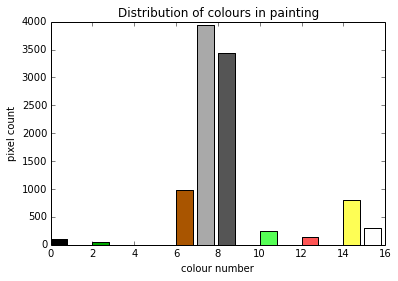

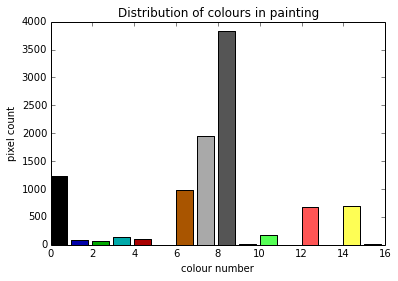

In [47]:
# compare colour distribution in simplified palette between
# members of the pair
%matplotlib inline
import matplotlib.pyplot as plt
palette = pt.CGApalette(ncolours=16)

mini1p = pt.paletteConvert(mini1,palette)
mini2p = pt.paletteConvert(mini2,palette)

pt.plotColourDistribution(mini1p.getcolors(),pt.unflatten(palette))
pt.plotColourDistribution(mini2p.getcolors(),pt.unflatten(palette))

plt.show()

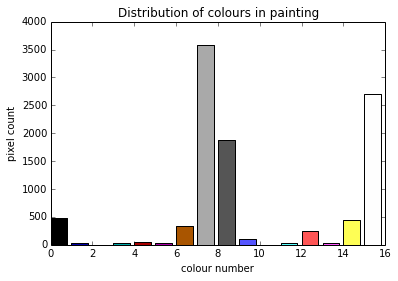

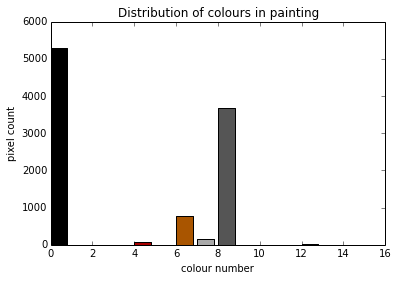

In [49]:
# repeat for a pair by different artists
# load a pair by the same artist
pairnum = 1001
mini1, mini2 = loadPair(pairs[pairnum])
# show (full) images
showImage(pairs[pairnum][0])
showImage(pairs[pairnum][1])

mini1p = pt.paletteConvert(mini1,palette)
mini2p = pt.paletteConvert(mini2,palette)

pt.plotColourDistribution(mini1p.getcolors(),pt.unflatten(palette))
pt.plotColourDistribution(mini2p.getcolors(),pt.unflatten(palette))

plt.show()

mean distance for sames, diffs:
(15307250.902000001, 16186985.088)




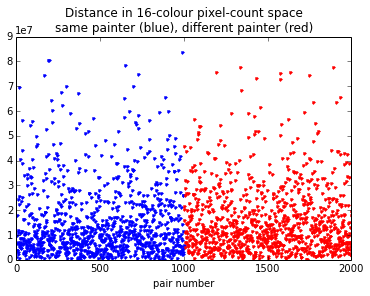

In [53]:
# for all pairs in "pairs", compute distances in colour space
import math
distance = []
for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    distance.append(sum((x1-data[inds[1]][i])**2 for i,x1 in enumerate(data[inds[0]])))
print('mean distance for sames, diffs:')
print(np.mean(distance[:npairs]), np.mean(distance[-npairs:]))
print('\n')

# plot Euclidean distance in pixel-count space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (not very exciting!)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),distance[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),distance[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Distance in 16-colour pixel-count space\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

mean distance for sames, diffs:
(632.45799999999997, 635.56799999999998)




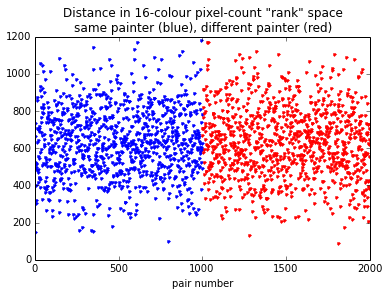

In [54]:
# repeat with a different norm ... (but which?)
# what about just rank difference by colour
distance2 = []
ncol = len(data[0])
for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    ranks1 = [aa[1] for aa in sorted(zip(data[inds[0]],range(ncol)))]
    ranks2 = [aa[1] for aa in sorted(zip(data[inds[1]],range(ncol)))]
    distance2.append(sum((r - ranks2[i])**2 for i,r in enumerate(ranks1)))
print('mean distance for sames, diffs:')
print(np.mean(distance2[:npairs]), np.mean(distance2[-npairs:]))
print('\n')

# plot rank distance in pixel-count space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (not exciting at all!!)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),distance2[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),distance2[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Distance in 16-colour pixel-count \"rank\" space\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

mean distance for sames, diffs:
(2.3809999999999998, 2.6280000000000001)




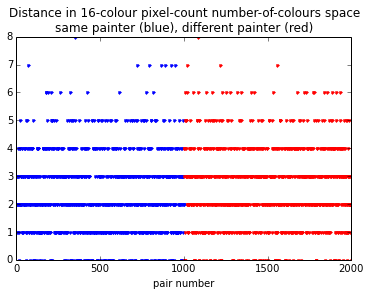

In [72]:
# repeat with yet another different norm ... (but which?)
# what about on/off switch if colour is more than 5%
distance3 = []
ncol = len(data[0])
thresh = 0.05*sum(data[0])
for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    onoff1 = [int(x>thresh) for x in data[inds[0]]]
    onoff2 = [int(x>thresh) for x in data[inds[1]]]
    distance3.append(sum((r - onoff2[i])**2 for i,r in enumerate(onoff1)))
print('mean distance for sames, diffs:')
print(np.mean(distance3[:npairs]), np.mean(distance3[-npairs:]))
print('\n')

# plot distance in threshold space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (slightly more exciting :-())
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),distance3[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),distance3[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Distance in 16-colour pixel-count number-of-colours space\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

mean distance for sames, diffs:
(3.056, 2.9220000000000002)




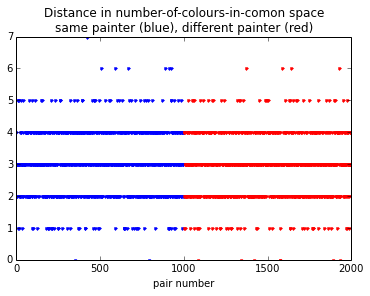

In [56]:
# repeat with yet another different norm ... (but which?)
# what about on/off switch if colour is more than 5%
# but this time count only common colours
distance4 = []
ncol = len(data[0])
thresh = 0.05*sum(data[0])
for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    onoff1 = [int(x>thresh) for x in data[inds[0]]]
    onoff2 = [int(x>thresh) for x in data[inds[1]]]
    distance4.append(sum(int(r+onoff2[i]==2) for i,r in enumerate(onoff1)))
print('mean distance for sames, diffs:')
print(np.mean(distance4[:npairs]), np.mean(distance4[-npairs:]))
print('\n')

# plot distance in threshold space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (slightly more exciting :-())
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),distance4[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),distance4[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Distance in number-of-colours-in-comon space\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

In [40]:
# Was ist hier eigentlich los????
# Let's look at a few particular pairs
pairnum = 7
inds = names.index(pairs[pairnum][0]), names.index(pairs[pairnum][1])

# show (full) images
showImage(pairs[pairnum][0])
showImage(pairs[pairnum][1])

# distance1
print('Euclidean')
print(zip(data[inds[0]],data[inds[1]]))
print(distance[pairnum])

# distance2
print('\nRank')
ranks1 = [aa[1] for aa in sorted(zip(data[inds[0]],range(ncol)))]
ranks2 = [aa[1] for aa in sorted(zip(data[inds[1]],range(ncol)))]
print(zip(ranks1,ranks2))
print(distance2[pairnum])


# distance3
print('\nThreshold')
onoff1 = [int(x>thresh) for x in data[inds[0]]]
onoff2 = [int(x>thresh) for x in data[inds[1]]]
print(zip(onoff1,onoff2))
print(distance3[pairnum])

# distance4
print('\nCommon Threshold')
onoff1 = [int(x>thresh) for x in data[inds[0]]]
onoff2 = [int(x>thresh) for x in data[inds[1]]]
print(zip(onoff1,onoff2))
print(distance4[pairnum])

Euclidean
[(4401, 326), (16, 0), (389, 0), (127, 0), (0, 189), (0, 37), (19, 1813), (218, 1331), (4760, 4226), (1, 0), (50, 0), (2, 0), (1, 1725), (0, 0), (5, 324), (11, 29)]
24629548

Rank
[(4, 1), (5, 2), (13, 3), (9, 9), (12, 10), (11, 11), (14, 13), (15, 15), (1, 5), (6, 4), (10, 14), (3, 0), (7, 7), (2, 12), (0, 6), (8, 8)]
304

Threshold
[(1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0)]
4

Common Threshold
[(1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0)]
1


In [59]:
# maybe hue/saturation/value is more interesting!!!
import PBNFeatures.cylindrical as cyl
reload(cyl)

pairnum=111

# show (full) images
showImage(pairs[pairnum][0])
showImage(pairs[pairnum][1])

# load miniatures
mini1,mini2 = loadPair(pairs[pairnum],mc='mini')

# compute hue/saturation/value statistics
hsvstats1 = cyl.hsv_stats(cyl.jpg_to_hsv(mini1),hue_bins=8)
hsvstats2 = cyl.hsv_stats(cyl.jpg_to_hsv(mini2),hue_bins=8)

hsvstats1, hsvstats2

({'hue_bins': [(1, 4257),
   (2, 1566),
   (4, 1236),
   (3, 1195),
   (0, 1151),
   (7, 233),
   (5, 215),
   (6, 147)],
  'sat_mean': 0.31982554989980638,
  'sat_std': 0.17927079368313953,
  'val_mean': 0.53280390624999996,
  'val_std': 0.15972204646915808},
 {'hue_bins': [(0, 2930),
   (1, 2383),
   (4, 2193),
   (5, 936),
   (3, 558),
   (2, 513),
   (7, 305),
   (6, 182)],
  'sat_mean': 0.30013307210308249,
  'sat_std': 0.24472636408764711,
  'val_mean': 0.53810351562500003,
  'val_std': 0.25758087457746082})

In [66]:
sum(pix for i,pix in hsvstats1['hue_bins'])/len(hsvstats1['hue_bins'])
sum(int(h[1]>1250) for h in hsvstats1['hue_bins'])

[1, 1, 0, 0, 0, 0, 0, 0]


In [42]:
# if it exists, load the json text file containing list of 
# 10 most prolific artists and the hsv stats of their paintings
# contained in train_1.zip and train_2.zip
#
# else, process all miniatures and write json file
#
import PBNFeatures.cylindrical as cyl
from PIL import Image
import os.path
import json
featureDir = '../Data/'
hsvstatsFile = featureDir + 'hsvstats_top10.json'
namesFile = featureDir + 'names_top10.json'
if (os.path.isfile(hsvstatsFile)):
    with open(hsvstatsFile,'r') as jsonfile:
        hsvstats = json.load(jsonfile)
        print('reading hsvstats file . . .')
    with open(namesFile,'r') as jsonfile:
        names = json.load(jsonfile)
        print('reading names file . . .')
else:
    # load all miniatures and compute saturation, value and hue
    # statistics for each (slow),
    # save filenames and pixel-counts by colour in two lists
    hsvstats = []
    names = []
    for portfolio in portfolios_uni:
        print('processing paintings by artist ' + portfolio[0] + ' . . .')
        for painting in portfolio[1]:
            names.append(painting)
            mininame = os.path.splitext(painting)[0] + '_mini_100_x_100.jpg'
            mini = Image.open(featureDir + 'FeatureData/' + mininame)
            hsvstats.append(cyl.hsv_stats(cyl.jpg_to_hsv(mini),hue_bins=16))
    # write hsvstats to json file
    # create json text file with list of hsv stats for each
    # artist's portfolio
    print('\nwriting json index file . . .')
    with open(hsvstatsFile,'w') as jsonfile:
        print('writing hsvstats file . . .')
        jsonfile.write(json.dumps(hsvstats,indent=2))
    with open(namesFile,'w') as jsonfile:
        print('writing names file . . .')
        jsonfile.write(json.dumps(names,indent=2))

processing paintings by artist 0eeac4ecff259dc515be795e1a76019a . . .
processing paintings by artist dd4989789d310581024ae2b9203d5439 . . .
processing paintings by artist 121fffad1eb6f7dff228b8a71b6aec72 . . .
processing paintings by artist 1a8d67dbb446bdc4298cc0be56932a38 . . .
processing paintings by artist ce3d8977aae5986601232aa58d15282a . . .
processing paintings by artist c16781c4321948227193214b68477a5c . . .
processing paintings by artist 3cc9a44380296d93e68b71a27643c25f . . .
processing paintings by artist d09f796f2b0aa11dffc88badd9806119 . . .
processing paintings by artist 5aabfc58470d01bb2362795a44a2603b . . .
processing paintings by artist db1318d32df7428076e03513ebf762bb . . .

writing json index file . . .
writing hsvstats file . . .
writing names file . . .


mean distances for sames, diffs:

sat_mean:
(0.14945313030559487, 0.17578197107524879)
sat_std:
(0.062499482436120551, 0.069801804401286291)
val_mean:
(0.1588812734375, 0.162189413671875)
val_std:
(0.05332681272084356, 0.05464402613826938)
dom_hue:
(2.4929999999999999, 2.7040000000000002)
dom_hue_count:
(2001.1289999999999, 2046.1679999999999)
hue_variety:
(0.81399999999999995, 0.78500000000000003)




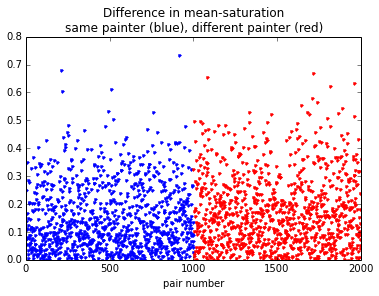

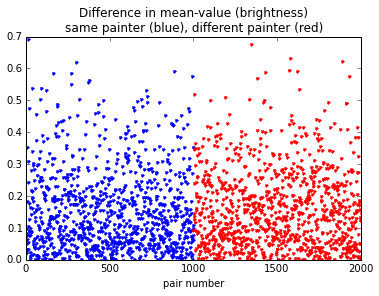

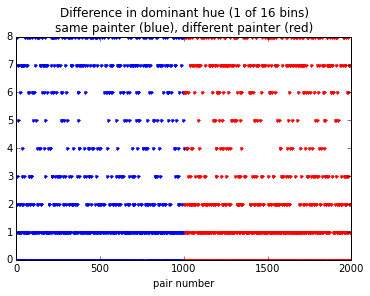

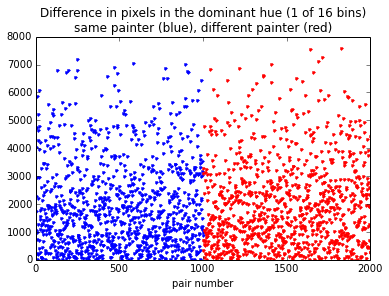

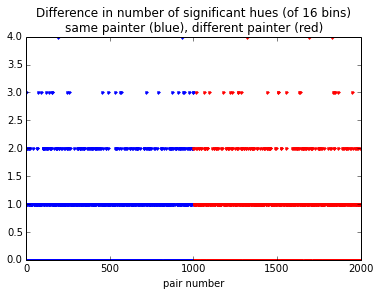

In [67]:
# for all pairs in "pairs", compute difference in 
# saturation and value means and std and the
# distance in dominant hue
import math
sat_mean_dist = []
sat_std_dist = []
val_mean_dist = []
val_std_dist = []
dom_hue_dist = []
dom_hue_count_dist = []
hue_variety_dist = []
nbins = len(hsvstats[0]['hue_bins'])
hue_ave = sum(pix for i,pix in hsvstats1['hue_bins'])/nbins

for pair in pairs:
    inds = names.index(pair[0]), names.index(pair[1])
    sat_mean_dist.append( \
                abs(hsvstats[inds[0]]['sat_mean'] - hsvstats[inds[1]]['sat_mean']))
    sat_std_dist.append( \
                abs(hsvstats[inds[0]]['sat_std'] - hsvstats[inds[1]]['sat_std']))
    val_mean_dist.append( \
                abs(hsvstats[inds[0]]['val_mean'] - hsvstats[inds[1]]['val_mean']))
    val_std_dist.append( \
                abs(hsvstats[inds[0]]['val_std'] - hsvstats[inds[1]]['val_std']))
    dom_hue_dist.append( \
                min( \
                    (hsvstats[inds[0]]['hue_bins'][0][0] - \
                     hsvstats[inds[1]]['hue_bins'][0][0]) % nbins, \
                    (hsvstats[inds[1]]['hue_bins'][0][0] - \
                     hsvstats[inds[0]]['hue_bins'][0][0]) % nbins) )
    dom_hue_count_dist.append( \
                abs(hsvstats[inds[0]]['hue_bins'][0][1] - \
                    hsvstats[inds[1]]['hue_bins'][0][1]) )
    # number of hue bins with more than the average number of pixels
    hue_variety_dist.append( \
                abs(sum(int(h[1]>1250) \
                        for h in hsvstats[inds[0]]['hue_bins']) - \
                    sum(int(h[1]>1250) \
                        for h in hsvstats[inds[1]]['hue_bins']) ) )

print('mean distances for sames, diffs:\n')
print('sat_mean:')
print(np.mean(sat_mean_dist[:npairs]), np.mean(sat_mean_dist[-npairs:]))
print('sat_std:')
print(np.mean(sat_std_dist[:npairs]), np.mean(sat_std_dist[-npairs:]))
print('val_mean:')
print(np.mean(val_mean_dist[:npairs]), np.mean(val_mean_dist[-npairs:]))
print('val_std:')
print(np.mean(val_std_dist[:npairs]), np.mean(val_std_dist[-npairs:]))
print('dom_hue:')
print(np.mean(dom_hue_dist[:npairs]), np.mean(dom_hue_dist[-npairs:]))
print('dom_hue_count:')
print(np.mean(dom_hue_count_dist[:npairs]), np.mean(dom_hue_count_dist[-npairs:]))
print('hue_variety:')
print(np.mean(hue_variety_dist[:npairs]), np.mean(hue_variety_dist[-npairs:]))
print('\n')

# plot Euclidean distance in hsv-stats space for
# pairs that are by same artist (blue) and
# pairs that are by different artists (red)
# (still not very exciting!)
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),sat_mean_dist[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),sat_mean_dist[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Difference in mean-saturation\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),val_mean_dist[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),val_mean_dist[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Difference in mean-value (brightness)\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),dom_hue_dist[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),dom_hue_dist[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Difference in dominant hue (1 of 16 bins)\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),dom_hue_count_dist[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),dom_hue_count_dist[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Difference in pixels in the dominant hue (1 of 16 bins)\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

fig = plt.figure()
ax = plt.axes()
plt.plot(range(npairs),hue_variety_dist[:npairs],linestyle='none',color='blue',marker='.')
plt.plot(range(npairs,2*npairs),hue_variety_dist[-npairs:],linestyle='none',color='red',marker='.')
plt.title('Difference in number of significant hues (of 16 bins)\n' \
        +'same painter (blue), different painter (red)')
plt.xlabel('pair number')
plt.show()

In [ ]:
# compute PCA for 16-colour CGA colour distributions in miniatures
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PBNFeatures.paletteTools as pt
import PBNPCA.pca as pbnpca
import os.path
import PIL.Image as Image
#import math
palette = pt.CGApalette(ncolours=16)
nc = len(palette)/3
featureDir = '../Data/FeatureData/'

In [ ]:
# compute the PC of data
reload(pbnpca)
ncomp = 15
pobj = pbnpca.pca(np.array(data),ncomp)

# pc:
pcs = []
for col in xrange(ncomp-1,-1,-1):
    # column to row
    pc = [vec[col] for vec in pobj['eigvecs']]
    # construct a "colours" list out of the pc (clumsy but should be okay)
    pc = [(a,i) for i,a in enumerate(pc)]
    pcs.append(pc)

In [ ]:
# plot leading eigenvectors (PC)
pt.plotColourDistribution(pcs[0],pt.unflatten(palette))
pt.plotColourDistribution(pcs[1],pt.unflatten(palette))
pt.plotColourDistribution(pcs[2],pt.unflatten(palette))
pt.plotColourDistribution(pcs[3],pt.unflatten(palette))
pt.plotColourDistribution(pcs[4],pt.unflatten(palette))
pt.plotColourDistribution(pcs[5],pt.unflatten(palette))
plt.show()

In [ ]:
# project row onto leading PC
pbnpca.pcaProject(data[750],pobj)[-8:]

In [ ]:
# compare full vector and projection onto first 8
print(data[750])
print('\n')
print(pbnpca.pcaTrunc(data[750],pobj,8))

#np.zeros((len(data[0]),1))
#np.array(pobj['meanvec']).reshape((len(data[0]),1))

In [ ]:
import random
a = random.sample(range(100),10)
order = [aa[1] for aa in sorted(zip(a,range(len(a))))]
print(a)
print(order)

In [ ]:
int(7<5)

In [ ]:
sum(data[0])

In [ ]:
# ideas for other features ...
#    saturation, lightness
#    texture, edges, dots
#    size
#    number of significant colours
# neural network idea?  (Auto-encoder-decoder)
# topic (=style) modelling